In [2]:
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import cifar10
from sklearn.datasets import fetch_lfw_people
import numpy as np
import random
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.utils.data.dataset import Dataset
import time

# Load CIFAR-10  dataset

In [3]:
(x_train_cifar, y_train_cifar), (x_test_cifar, y_test_cifar) = cifar10.load_data()
print(x_train_cifar.shape)
print(x_test_cifar.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


# Load Labelled Faces in the Wild dataset

In [4]:
lfw_people = fetch_lfw_people(min_faces_per_person=3,resize=0.515)
lfw_people.images.shape

(7606, 64, 48)

In [5]:
#reshape to 32*32*3
x_people = np.reshape(lfw_people.data,[lfw_people.data.shape[0],32,32,3])

In [6]:
#take 7000 faces and label with '10'
x_train_people = x_people[:5000]
y_train_people = np.ones((5000,1))*10
x_test_people = x_people[5000:7000]
y_test_people = np.ones((2000,1))*10
print(x_train_people.shape)
print(x_test_people.shape)

(5000, 32, 32, 3)
(2000, 32, 32, 3)


# Merge 2 dataset

In [7]:
x_train = np.concatenate((x_train_cifar,x_train_people))
x_test = np.concatenate((x_test_cifar,x_test_people))
y_train = np.concatenate((y_train_cifar,y_train_people))
y_test = np.concatenate((y_test_cifar,y_test_people))
print(x_train.shape)
print(x_test.shape)

(55000, 32, 32, 3)
(12000, 32, 32, 3)


# Normalize data

In [9]:
# Normalize data
x_train_norm = x_train.astype('float32') / 255
x_test_norm = x_test.astype('float32') / 255

# Mean subtraction
x_train_mean = np.mean(x_train_norm, axis=0)
x_train_norm -= x_train_mean
x_test_norm -= x_train_mean

# Split data into batches

In [10]:
class MyDataset(Dataset):
    def __init__(self,x,y):
        self.data = x
        self.target = y
    def __len__(self):
        return len(self.target)
    def __getitem__(self,index):
        return self.data[index],self.target[index]

# Model

In [11]:
class CNN(nn.Module):
    def __init__(self,num_class):
        super(CNN,self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=64,kernel_size=5,padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=3)
        self.norm1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(in_channels=64,out_channels=64,kernel_size=5,padding=1)
        self.norm2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=3)
        self.relu2 = nn.ReLU()
        
        self.fc1 = nn.Linear(256,num_class)
    
    def forward(self,input):
        batch_size = input.size(0)
        input = input.view(batch_size,3,32,-1)
        
        output1 = self.conv1(input)
        output1 = self.pool1(output1)
        output1 = self.norm1(output1)
        output1 = self.relu1(output1)
        
        output2 = self.conv2(output1)
        output2 = self.norm2(output2)
        output2 = self.pool2(output2)
        output2 = self.relu2(output2)
        
        output2 = output2.view(-1,256)
        output = self.fc1(output2)
        return output

In [12]:
class Classifier(object):
    def __init__(self,args,use_cuda=True):
        [num_class,lr,batch_size,epochs,trained_model,es] = args
        self.device = torch.device('cuda' if use_cuda else 'cpu')
        self.model = CNN(num_class).to(self.device)
        
        self.optimizer = optim.Adam(self.model.parameters(),lr=lr)
        self.lossF = nn.CrossEntropyLoss()
        
        self.batch_size = batch_size
        self.lr = lr
        self.epochs = epochs
        self.trained_model = trained_model
        self.es=es
    def train_batch(self,train_generator,epoch=0):
        total_loss =0
        total_image =0
        start_time = time.time()
        iterations = 0
        
        self.model.train()
        for batch,(images,targets) in enumerate(train_generator):
            self.optimizer.zero_grad()
            images = images.to(self.device)
            targets = targets.to(self.device,dtype=torch.long).view(self.batch_size)
            label_score = self.model(images)
            loss = self.lossF(label_score,targets)
            loss.backward()
            self.optimizer.step()
            
            iterations += 1
            total_loss += loss.item()
            total_image += images.size(0)
            _, predicted = torch.max(label_score, 1)
            correct = (predicted == targets).sum()
        
            cur_loss = total_loss/iterations
            elapsed = time.time() - start_time
            if batch % 10==0:
                print('-' * 89)
                print('| TRAINING | epoch {:3d} | batch {:5d} | images {:5d} | lr {:02.2f} | '
                  'images/s {:5.2f} | loss {:5.2f} | accuracy {:5.2f} %'.format(epoch, batch+1, total_image,
                                                                        self.lr, total_image/elapsed, cur_loss,
                                                                        100*correct/self.batch_size))
                print('-' * 89)
    
    def evaluate_batch(self,test_generator):
        start_time = time.time()
        self.model.eval()
        total_loss = 0
        total_image = 0
        iterations = 0
        correct = 0
        with torch.no_grad():
            for images,targets in test_generator:
                images = images.to(self.device)
                targets = targets.to(self.device,dtype=torch.long).view(self.batch_size)
                label_score = self.model(images)
                loss = self.lossF(label_score,targets)
                
                iterations +=1
                total_loss += loss.item()
                total_image += images.size(0)
                _, predicted = torch.max(label_score, 1)
                correct += (predicted == targets).sum()
        
        cur_loss = total_loss / iterations
        elapsed = time.time() - start_time
        accuracy = 100*correct/12000
        print('-' * 89)
        print('| EVALUATION | images {:5d} | lr {:02.2f} | images/s {:5.2f} | '
              'loss {:5.2f} | accuracy {:5.2f} %'.format(total_image, self.lr,
                                                  total_image / elapsed, cur_loss,accuracy))
        print('-' * 89)
        return cur_loss, total_image, elapsed,accuracy
    
    def train(self,x_train,y_train,x_test,y_test):
        train_para = {'batch_size':self.batch_size,'shuffle':True,'drop_last':True}
        test_para = {'batch_size':self.batch_size,'shuffle':False,'drop_last':True}
        train_set = MyDataset(x_train,y_train)
        test_set = MyDataset(x_test,y_test)
        train_generator = DataLoader(train_set,**train_para)
        test_generator = DataLoader(test_set,**test_para)
        
        best_test_loss = 0
        best_epoch = 0
        nimp = 0
        
        for epoch in range(1,self.epochs+1):
            epoch_start_time = time.time()
            self.train_batch(train_generator,epoch)
            test_loss,test_total_image, test_elapsed,test_accuracy = self.evaluate_batch(test_generator)
            print('-' * 89)
            print('| EVALUATING | end of epoch {:3d} | time: {:5.2f}s | test loss {:5.2f} | test accuracy {:5.2f}% | '
                      'test_images {:5d} | images/s {:5.2f}'.format(epoch, (time.time() - epoch_start_time),
                                                                test_loss,test_accuracy, test_total_image,
                                                                test_elapsed))
            print('-' * 89)
            
            if not best_test_loss or test_loss < best_test_loss:
                nimp = 0
                best_epoch = epoch
                self.model.to("cpu")
                torch.save(self.model.state_dict(),self.trained_model)
                self.model.to(self.device)
                    
                best_test_loss = test_loss
                    
                print('-' * 89)
                print('| NEW IMPROVEMENT | Save the model to file')
                print('-' * 89)
                    
            else:
                nimp += 1
                if nimp > self.es:

                    print('-' * 89)
                    print("Early Stopping at epoch {:3d}".format(epoch))
                    print('-' * 89)
                    return

# Train model

In [13]:
num_class = 11
lr = 0.001
batch_size=32
epochs = 100
es=3
trained_model = 'test.m'
args = [num_class,lr,batch_size,epochs,trained_model,es]

In [14]:
cnn_model = Classifier(args,True)
cnn_model.train(x_train_norm,y_train,x_test_norm,y_test)

-----------------------------------------------------------------------------------------
| TRAINING | epoch   1 | batch     1 | images    32 | lr 0.00 | images/s 17.96 | loss  2.37 | accuracy  9.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   1 | batch    11 | images   352 | lr 0.00 | images/s 181.03 | loss  2.23 | accuracy 21.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   1 | batch    21 | images   672 | lr 0.00 | images/s 318.50 | loss  2.21 | accuracy 21.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   1 | batch    3

-----------------------------------------------------------------------------------------
| TRAINING | epoch   1 | batch   301 | images  9632 | lr 0.00 | images/s 1443.08 | loss  1.82 | accuracy 43.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   1 | batch   311 | images  9952 | lr 0.00 | images/s 1455.86 | loss  1.82 | accuracy 28.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   1 | batch   321 | images 10272 | lr 0.00 | images/s 1467.44 | loss  1.81 | accuracy 37.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   1 | batch 

-----------------------------------------------------------------------------------------
| TRAINING | epoch   1 | batch   581 | images 18592 | lr 0.00 | images/s 1657.69 | loss  1.70 | accuracy 37.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   1 | batch   591 | images 18912 | lr 0.00 | images/s 1662.71 | loss  1.70 | accuracy 34.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   1 | batch   601 | images 19232 | lr 0.00 | images/s 1666.82 | loss  1.70 | accuracy 46.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   1 | batch 

-----------------------------------------------------------------------------------------
| TRAINING | epoch   1 | batch   861 | images 27552 | lr 0.00 | images/s 1743.84 | loss  1.63 | accuracy 31.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   1 | batch   871 | images 27872 | lr 0.00 | images/s 1746.51 | loss  1.63 | accuracy 50.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   1 | batch   881 | images 28192 | lr 0.00 | images/s 1748.79 | loss  1.63 | accuracy 43.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   1 | batch 

-----------------------------------------------------------------------------------------
| TRAINING | epoch   1 | batch  1151 | images 36832 | lr 0.00 | images/s 1797.08 | loss  1.59 | accuracy 46.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   1 | batch  1161 | images 37152 | lr 0.00 | images/s 1798.60 | loss  1.58 | accuracy 56.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   1 | batch  1171 | images 37472 | lr 0.00 | images/s 1800.06 | loss  1.58 | accuracy 62.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   1 | batch 

-----------------------------------------------------------------------------------------
| TRAINING | epoch   1 | batch  1431 | images 45792 | lr 0.00 | images/s 1830.52 | loss  1.55 | accuracy 62.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   1 | batch  1441 | images 46112 | lr 0.00 | images/s 1831.67 | loss  1.55 | accuracy 68.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   1 | batch  1451 | images 46432 | lr 0.00 | images/s 1832.80 | loss  1.55 | accuracy 40.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   1 | batch 

-----------------------------------------------------------------------------------------
| TRAINING | epoch   1 | batch  1711 | images 54752 | lr 0.00 | images/s 1853.71 | loss  1.52 | accuracy 56.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| EVALUATION | images 12000 | lr 0.00 | images/s 4802.79 | loss  1.22 | accuracy 56.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| EVALUATING | end of epoch   1 | time: 32.15s | test loss  1.22 | test accuracy 56.00% | test_images 12000 | images/s  2.50
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| NEW IMPROVEMENT | Save the model to file


-----------------------------------------------------------------------------------------
| TRAINING | epoch   2 | batch   261 | images  8352 | lr 0.00 | images/s 1943.56 | loss  1.32 | accuracy 62.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   2 | batch   271 | images  8672 | lr 0.00 | images/s 1945.24 | loss  1.33 | accuracy 65.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   2 | batch   281 | images  8992 | lr 0.00 | images/s 1946.61 | loss  1.32 | accuracy 62.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   2 | batch 

-----------------------------------------------------------------------------------------
| TRAINING | epoch   2 | batch   541 | images 17312 | lr 0.00 | images/s 1962.61 | loss  1.32 | accuracy 43.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   2 | batch   551 | images 17632 | lr 0.00 | images/s 1959.86 | loss  1.32 | accuracy 46.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   2 | batch   561 | images 17952 | lr 0.00 | images/s 1959.95 | loss  1.32 | accuracy 53.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   2 | batch 

-----------------------------------------------------------------------------------------
| TRAINING | epoch   2 | batch   821 | images 26272 | lr 0.00 | images/s 1971.48 | loss  1.31 | accuracy 43.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   2 | batch   831 | images 26592 | lr 0.00 | images/s 1971.94 | loss  1.31 | accuracy 56.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   2 | batch   841 | images 26912 | lr 0.00 | images/s 1972.24 | loss  1.31 | accuracy 68.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   2 | batch 

-----------------------------------------------------------------------------------------
| TRAINING | epoch   2 | batch  1101 | images 35232 | lr 0.00 | images/s 1975.97 | loss  1.31 | accuracy 62.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   2 | batch  1111 | images 35552 | lr 0.00 | images/s 1976.28 | loss  1.30 | accuracy 65.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   2 | batch  1121 | images 35872 | lr 0.00 | images/s 1976.69 | loss  1.30 | accuracy 68.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   2 | batch 

-----------------------------------------------------------------------------------------
| TRAINING | epoch   2 | batch  1381 | images 44192 | lr 0.00 | images/s 1978.01 | loss  1.30 | accuracy 68.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   2 | batch  1391 | images 44512 | lr 0.00 | images/s 1978.29 | loss  1.30 | accuracy 43.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   2 | batch  1401 | images 44832 | lr 0.00 | images/s 1978.56 | loss  1.30 | accuracy 56.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   2 | batch 

-----------------------------------------------------------------------------------------
| TRAINING | epoch   2 | batch  1661 | images 53152 | lr 0.00 | images/s 1981.19 | loss  1.30 | accuracy 53.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   2 | batch  1671 | images 53472 | lr 0.00 | images/s 1981.29 | loss  1.30 | accuracy 56.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   2 | batch  1681 | images 53792 | lr 0.00 | images/s 1981.36 | loss  1.30 | accuracy 50.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   2 | batch 

-----------------------------------------------------------------------------------------
| TRAINING | epoch   3 | batch   201 | images  6432 | lr 0.00 | images/s 1994.75 | loss  1.22 | accuracy 59.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   3 | batch   211 | images  6752 | lr 0.00 | images/s 1995.81 | loss  1.23 | accuracy 56.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   3 | batch   221 | images  7072 | lr 0.00 | images/s 1996.49 | loss  1.22 | accuracy 68.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   3 | batch 

-----------------------------------------------------------------------------------------
| TRAINING | epoch   3 | batch   481 | images 15392 | lr 0.00 | images/s 2002.10 | loss  1.22 | accuracy 59.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   3 | batch   491 | images 15712 | lr 0.00 | images/s 2002.45 | loss  1.22 | accuracy 65.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   3 | batch   501 | images 16032 | lr 0.00 | images/s 2002.30 | loss  1.22 | accuracy 59.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   3 | batch 

-----------------------------------------------------------------------------------------
| TRAINING | epoch   3 | batch   771 | images 24672 | lr 0.00 | images/s 1975.92 | loss  1.21 | accuracy 62.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   3 | batch   781 | images 24992 | lr 0.00 | images/s 1976.36 | loss  1.21 | accuracy 62.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   3 | batch   791 | images 25312 | lr 0.00 | images/s 1975.91 | loss  1.21 | accuracy 59.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   3 | batch 

-----------------------------------------------------------------------------------------
| TRAINING | epoch   3 | batch  1061 | images 33952 | lr 0.00 | images/s 1943.48 | loss  1.21 | accuracy 68.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   3 | batch  1071 | images 34272 | lr 0.00 | images/s 1943.15 | loss  1.21 | accuracy 59.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   3 | batch  1081 | images 34592 | lr 0.00 | images/s 1942.72 | loss  1.21 | accuracy 65.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   3 | batch 

-----------------------------------------------------------------------------------------
| TRAINING | epoch   3 | batch  1341 | images 42912 | lr 0.00 | images/s 1946.17 | loss  1.20 | accuracy 40.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   3 | batch  1351 | images 43232 | lr 0.00 | images/s 1946.11 | loss  1.20 | accuracy 56.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   3 | batch  1361 | images 43552 | lr 0.00 | images/s 1946.18 | loss  1.20 | accuracy 43.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   3 | batch 

-----------------------------------------------------------------------------------------
| TRAINING | epoch   3 | batch  1621 | images 51872 | lr 0.00 | images/s 1936.96 | loss  1.20 | accuracy 50.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   3 | batch  1631 | images 52192 | lr 0.00 | images/s 1936.29 | loss  1.20 | accuracy 62.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   3 | batch  1641 | images 52512 | lr 0.00 | images/s 1936.62 | loss  1.20 | accuracy 43.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   3 | batch 

| TRAINING | epoch   4 | batch   151 | images  4832 | lr 0.00 | images/s 1854.97 | loss  1.14 | accuracy 53.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   4 | batch   161 | images  5152 | lr 0.00 | images/s 1849.89 | loss  1.14 | accuracy 59.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   4 | batch   171 | images  5472 | lr 0.00 | images/s 1839.85 | loss  1.14 | accuracy 75.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   4 | batch   181 | images  5792 | lr 0.00 | images/s 1841.49 | loss  1.14 | accuracy 53.00 %
--------

-----------------------------------------------------------------------------------------
| TRAINING | epoch   4 | batch   451 | images 14432 | lr 0.00 | images/s 1838.09 | loss  1.14 | accuracy 46.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   4 | batch   461 | images 14752 | lr 0.00 | images/s 1840.38 | loss  1.14 | accuracy 65.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   4 | batch   471 | images 15072 | lr 0.00 | images/s 1842.91 | loss  1.14 | accuracy 62.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   4 | batch 

-----------------------------------------------------------------------------------------
| TRAINING | epoch   4 | batch   741 | images 23712 | lr 0.00 | images/s 1863.68 | loss  1.14 | accuracy 68.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   4 | batch   751 | images 24032 | lr 0.00 | images/s 1865.58 | loss  1.14 | accuracy 46.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   4 | batch   761 | images 24352 | lr 0.00 | images/s 1866.71 | loss  1.15 | accuracy 62.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   4 | batch 

-----------------------------------------------------------------------------------------
| TRAINING | epoch   4 | batch  1021 | images 32672 | lr 0.00 | images/s 1892.04 | loss  1.14 | accuracy 40.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   4 | batch  1031 | images 32992 | lr 0.00 | images/s 1893.02 | loss  1.14 | accuracy 50.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   4 | batch  1041 | images 33312 | lr 0.00 | images/s 1893.87 | loss  1.14 | accuracy 65.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   4 | batch 

-----------------------------------------------------------------------------------------
| TRAINING | epoch   4 | batch  1311 | images 41952 | lr 0.00 | images/s 1899.93 | loss  1.14 | accuracy 40.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   4 | batch  1321 | images 42272 | lr 0.00 | images/s 1899.91 | loss  1.14 | accuracy 65.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   4 | batch  1331 | images 42592 | lr 0.00 | images/s 1899.47 | loss  1.14 | accuracy 65.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   4 | batch 

-----------------------------------------------------------------------------------------
| TRAINING | epoch   4 | batch  1591 | images 50912 | lr 0.00 | images/s 1909.09 | loss  1.14 | accuracy 62.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   4 | batch  1601 | images 51232 | lr 0.00 | images/s 1909.70 | loss  1.14 | accuracy 46.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   4 | batch  1611 | images 51552 | lr 0.00 | images/s 1910.22 | loss  1.14 | accuracy 59.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   4 | batch 

-----------------------------------------------------------------------------------------
| TRAINING | epoch   5 | batch   131 | images  4192 | lr 0.00 | images/s 1969.90 | loss  1.08 | accuracy 59.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   5 | batch   141 | images  4512 | lr 0.00 | images/s 1967.04 | loss  1.08 | accuracy 62.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   5 | batch   151 | images  4832 | lr 0.00 | images/s 1966.10 | loss  1.08 | accuracy 56.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   5 | batch 

-----------------------------------------------------------------------------------------
| TRAINING | epoch   5 | batch   411 | images 13152 | lr 0.00 | images/s 1978.27 | loss  1.08 | accuracy 62.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   5 | batch   421 | images 13472 | lr 0.00 | images/s 1978.60 | loss  1.08 | accuracy 68.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   5 | batch   431 | images 13792 | lr 0.00 | images/s 1978.64 | loss  1.08 | accuracy 65.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   5 | batch 

-----------------------------------------------------------------------------------------
| TRAINING | epoch   5 | batch   691 | images 22112 | lr 0.00 | images/s 1953.20 | loss  1.08 | accuracy 71.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   5 | batch   701 | images 22432 | lr 0.00 | images/s 1953.58 | loss  1.08 | accuracy 40.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   5 | batch   711 | images 22752 | lr 0.00 | images/s 1953.10 | loss  1.08 | accuracy 46.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   5 | batch 

-----------------------------------------------------------------------------------------
| TRAINING | epoch   5 | batch   971 | images 31072 | lr 0.00 | images/s 1956.60 | loss  1.08 | accuracy 71.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   5 | batch   981 | images 31392 | lr 0.00 | images/s 1956.53 | loss  1.08 | accuracy 62.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   5 | batch   991 | images 31712 | lr 0.00 | images/s 1956.89 | loss  1.08 | accuracy 62.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   5 | batch 

-----------------------------------------------------------------------------------------
| TRAINING | epoch   5 | batch  1251 | images 40032 | lr 0.00 | images/s 1945.94 | loss  1.08 | accuracy 59.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   5 | batch  1261 | images 40352 | lr 0.00 | images/s 1946.40 | loss  1.08 | accuracy 71.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   5 | batch  1271 | images 40672 | lr 0.00 | images/s 1946.56 | loss  1.08 | accuracy 68.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   5 | batch 

-----------------------------------------------------------------------------------------
| TRAINING | epoch   5 | batch  1531 | images 48992 | lr 0.00 | images/s 1940.58 | loss  1.09 | accuracy 65.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   5 | batch  1541 | images 49312 | lr 0.00 | images/s 1940.33 | loss  1.09 | accuracy 59.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   5 | batch  1551 | images 49632 | lr 0.00 | images/s 1940.39 | loss  1.09 | accuracy 56.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   5 | batch 

| TRAINING | epoch   6 | batch    61 | images  1952 | lr 0.00 | images/s 1941.00 | loss  1.03 | accuracy 56.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   6 | batch    71 | images  2272 | lr 0.00 | images/s 1943.06 | loss  1.02 | accuracy 59.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   6 | batch    81 | images  2592 | lr 0.00 | images/s 1941.70 | loss  1.03 | accuracy 62.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   6 | batch    91 | images  2912 | lr 0.00 | images/s 1949.09 | loss  1.04 | accuracy 50.00 %
--------

-----------------------------------------------------------------------------------------
| TRAINING | epoch   6 | batch   361 | images 11552 | lr 0.00 | images/s 1970.06 | loss  1.03 | accuracy 62.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   6 | batch   371 | images 11872 | lr 0.00 | images/s 1970.98 | loss  1.03 | accuracy 71.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   6 | batch   381 | images 12192 | lr 0.00 | images/s 1972.18 | loss  1.03 | accuracy 56.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   6 | batch 

-----------------------------------------------------------------------------------------
| TRAINING | epoch   6 | batch   651 | images 20832 | lr 0.00 | images/s 1929.10 | loss  1.03 | accuracy 65.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   6 | batch   661 | images 21152 | lr 0.00 | images/s 1927.65 | loss  1.03 | accuracy 68.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   6 | batch   671 | images 21472 | lr 0.00 | images/s 1925.55 | loss  1.03 | accuracy 71.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   6 | batch 

-----------------------------------------------------------------------------------------
| TRAINING | epoch   6 | batch   941 | images 30112 | lr 0.00 | images/s 1927.77 | loss  1.03 | accuracy 46.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   6 | batch   951 | images 30432 | lr 0.00 | images/s 1928.74 | loss  1.03 | accuracy 56.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   6 | batch   961 | images 30752 | lr 0.00 | images/s 1928.88 | loss  1.03 | accuracy 68.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   6 | batch 

-----------------------------------------------------------------------------------------
| TRAINING | epoch   6 | batch  1221 | images 39072 | lr 0.00 | images/s 1931.20 | loss  1.04 | accuracy 62.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   6 | batch  1231 | images 39392 | lr 0.00 | images/s 1931.59 | loss  1.04 | accuracy 71.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   6 | batch  1241 | images 39712 | lr 0.00 | images/s 1932.14 | loss  1.04 | accuracy 78.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   6 | batch 

-----------------------------------------------------------------------------------------
| TRAINING | epoch   6 | batch  1511 | images 48352 | lr 0.00 | images/s 1929.36 | loss  1.04 | accuracy 59.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   6 | batch  1521 | images 48672 | lr 0.00 | images/s 1929.04 | loss  1.05 | accuracy 56.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   6 | batch  1531 | images 48992 | lr 0.00 | images/s 1928.94 | loss  1.05 | accuracy 71.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   6 | batch 

-----------------------------------------------------------------------------------------
| TRAINING | epoch   7 | batch    61 | images  1952 | lr 0.00 | images/s 1990.76 | loss  0.98 | accuracy 65.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   7 | batch    71 | images  2272 | lr 0.00 | images/s 1997.11 | loss  0.98 | accuracy 81.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   7 | batch    81 | images  2592 | lr 0.00 | images/s 1998.06 | loss  0.98 | accuracy 50.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   7 | batch 

| TRAINING | epoch   7 | batch   341 | images 10912 | lr 0.00 | images/s 1893.52 | loss  0.98 | accuracy 68.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   7 | batch   351 | images 11232 | lr 0.00 | images/s 1891.25 | loss  0.98 | accuracy 59.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   7 | batch   361 | images 11552 | lr 0.00 | images/s 1889.73 | loss  0.98 | accuracy 78.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   7 | batch   371 | images 11872 | lr 0.00 | images/s 1888.74 | loss  0.98 | accuracy 62.00 %
--------

| TRAINING | epoch   7 | batch   621 | images 19872 | lr 0.00 | images/s 1874.37 | loss  0.99 | accuracy 65.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   7 | batch   631 | images 20192 | lr 0.00 | images/s 1875.78 | loss  0.99 | accuracy 65.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   7 | batch   641 | images 20512 | lr 0.00 | images/s 1876.98 | loss  0.99 | accuracy 68.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   7 | batch   651 | images 20832 | lr 0.00 | images/s 1878.06 | loss  0.99 | accuracy 62.00 %
--------

-----------------------------------------------------------------------------------------
| TRAINING | epoch   7 | batch   921 | images 29472 | lr 0.00 | images/s 1897.11 | loss  1.00 | accuracy 65.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   7 | batch   931 | images 29792 | lr 0.00 | images/s 1898.26 | loss  1.00 | accuracy 59.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   7 | batch   941 | images 30112 | lr 0.00 | images/s 1899.21 | loss  1.00 | accuracy 65.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   7 | batch 

-----------------------------------------------------------------------------------------
| TRAINING | epoch   7 | batch  1201 | images 38432 | lr 0.00 | images/s 1906.18 | loss  1.00 | accuracy 53.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   7 | batch  1211 | images 38752 | lr 0.00 | images/s 1906.48 | loss  1.00 | accuracy 62.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   7 | batch  1221 | images 39072 | lr 0.00 | images/s 1906.92 | loss  1.00 | accuracy 56.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   7 | batch 

-----------------------------------------------------------------------------------------
| TRAINING | epoch   7 | batch  1481 | images 47392 | lr 0.00 | images/s 1912.68 | loss  1.00 | accuracy 40.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   7 | batch  1491 | images 47712 | lr 0.00 | images/s 1912.23 | loss  1.00 | accuracy 59.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   7 | batch  1501 | images 48032 | lr 0.00 | images/s 1912.44 | loss  1.00 | accuracy 62.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   7 | batch 

-----------------------------------------------------------------------------------------
| TRAINING | epoch   8 | batch    31 | images   992 | lr 0.00 | images/s 1957.15 | loss  0.95 | accuracy 68.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   8 | batch    41 | images  1312 | lr 0.00 | images/s 1962.68 | loss  0.97 | accuracy 62.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   8 | batch    51 | images  1632 | lr 0.00 | images/s 1962.50 | loss  0.96 | accuracy 78.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   8 | batch 

-----------------------------------------------------------------------------------------
| TRAINING | epoch   8 | batch   311 | images  9952 | lr 0.00 | images/s 1929.12 | loss  0.97 | accuracy 65.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   8 | batch   321 | images 10272 | lr 0.00 | images/s 1929.94 | loss  0.97 | accuracy 75.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   8 | batch   331 | images 10592 | lr 0.00 | images/s 1931.93 | loss  0.97 | accuracy 43.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   8 | batch 

-----------------------------------------------------------------------------------------
| TRAINING | epoch   8 | batch   601 | images 19232 | lr 0.00 | images/s 1907.09 | loss  0.97 | accuracy 71.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   8 | batch   611 | images 19552 | lr 0.00 | images/s 1904.43 | loss  0.97 | accuracy 65.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   8 | batch   621 | images 19872 | lr 0.00 | images/s 1905.33 | loss  0.97 | accuracy 75.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   8 | batch 

-----------------------------------------------------------------------------------------
| TRAINING | epoch   8 | batch   891 | images 28512 | lr 0.00 | images/s 1917.78 | loss  0.97 | accuracy 65.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   8 | batch   901 | images 28832 | lr 0.00 | images/s 1918.20 | loss  0.97 | accuracy 71.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   8 | batch   911 | images 29152 | lr 0.00 | images/s 1918.85 | loss  0.97 | accuracy 84.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   8 | batch 

-----------------------------------------------------------------------------------------
| TRAINING | epoch   8 | batch  1181 | images 37792 | lr 0.00 | images/s 1922.07 | loss  0.97 | accuracy 84.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   8 | batch  1191 | images 38112 | lr 0.00 | images/s 1922.73 | loss  0.97 | accuracy 65.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   8 | batch  1201 | images 38432 | lr 0.00 | images/s 1923.44 | loss  0.97 | accuracy 62.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   8 | batch 

-----------------------------------------------------------------------------------------
| TRAINING | epoch   8 | batch  1461 | images 46752 | lr 0.00 | images/s 1927.23 | loss  0.97 | accuracy 71.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   8 | batch  1471 | images 47072 | lr 0.00 | images/s 1927.38 | loss  0.97 | accuracy 65.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   8 | batch  1481 | images 47392 | lr 0.00 | images/s 1927.69 | loss  0.97 | accuracy 68.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   8 | batch 

| TRAINING | epoch   9 | batch    11 | images   352 | lr 0.00 | images/s 1948.78 | loss  0.92 | accuracy 56.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   9 | batch    21 | images   672 | lr 0.00 | images/s 1946.41 | loss  0.93 | accuracy 65.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   9 | batch    31 | images   992 | lr 0.00 | images/s 1955.22 | loss  0.94 | accuracy 62.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   9 | batch    41 | images  1312 | lr 0.00 | images/s 1959.72 | loss  0.93 | accuracy 68.00 %
--------

-----------------------------------------------------------------------------------------
| TRAINING | epoch   9 | batch   311 | images  9952 | lr 0.00 | images/s 1948.40 | loss  0.92 | accuracy 62.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   9 | batch   321 | images 10272 | lr 0.00 | images/s 1948.64 | loss  0.92 | accuracy 59.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   9 | batch   331 | images 10592 | lr 0.00 | images/s 1947.96 | loss  0.92 | accuracy 62.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   9 | batch 

-----------------------------------------------------------------------------------------
| TRAINING | epoch   9 | batch   591 | images 18912 | lr 0.00 | images/s 1956.42 | loss  0.92 | accuracy 68.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   9 | batch   601 | images 19232 | lr 0.00 | images/s 1955.60 | loss  0.92 | accuracy 68.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   9 | batch   611 | images 19552 | lr 0.00 | images/s 1956.29 | loss  0.92 | accuracy 50.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   9 | batch 

-----------------------------------------------------------------------------------------
| TRAINING | epoch   9 | batch   871 | images 27872 | lr 0.00 | images/s 1957.72 | loss  0.93 | accuracy 46.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   9 | batch   881 | images 28192 | lr 0.00 | images/s 1958.04 | loss  0.93 | accuracy 65.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   9 | batch   891 | images 28512 | lr 0.00 | images/s 1957.68 | loss  0.93 | accuracy 62.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   9 | batch 

-----------------------------------------------------------------------------------------
| TRAINING | epoch   9 | batch  1151 | images 36832 | lr 0.00 | images/s 1953.92 | loss  0.94 | accuracy 81.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   9 | batch  1161 | images 37152 | lr 0.00 | images/s 1954.19 | loss  0.94 | accuracy 65.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   9 | batch  1171 | images 37472 | lr 0.00 | images/s 1954.41 | loss  0.94 | accuracy 62.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   9 | batch 

-----------------------------------------------------------------------------------------
| TRAINING | epoch   9 | batch  1441 | images 46112 | lr 0.00 | images/s 1944.76 | loss  0.94 | accuracy 68.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   9 | batch  1451 | images 46432 | lr 0.00 | images/s 1945.08 | loss  0.94 | accuracy 68.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   9 | batch  1461 | images 46752 | lr 0.00 | images/s 1944.75 | loss  0.94 | accuracy 68.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch   9 | batch 

-----------------------------------------------------------------------------------------
| EVALUATION | images 12000 | lr 0.00 | images/s 4753.77 | loss  1.06 | accuracy 62.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| EVALUATING | end of epoch   9 | time: 30.93s | test loss  1.06 | test accuracy 62.00% | test_images 12000 | images/s  2.52
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch  10 | batch     1 | images    32 | lr 0.00 | images/s 1776.31 | loss  0.86 | accuracy 68.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch  10 | batch    11 | imag

-----------------------------------------------------------------------------------------
| TRAINING | epoch  10 | batch   271 | images  8672 | lr 0.00 | images/s 1927.07 | loss  0.88 | accuracy 53.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch  10 | batch   281 | images  8992 | lr 0.00 | images/s 1926.63 | loss  0.89 | accuracy 68.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch  10 | batch   291 | images  9312 | lr 0.00 | images/s 1924.43 | loss  0.88 | accuracy 62.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch  10 | batch 

-----------------------------------------------------------------------------------------
| TRAINING | epoch  10 | batch   551 | images 17632 | lr 0.00 | images/s 1901.95 | loss  0.90 | accuracy 59.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch  10 | batch   561 | images 17952 | lr 0.00 | images/s 1899.56 | loss  0.90 | accuracy 62.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch  10 | batch   571 | images 18272 | lr 0.00 | images/s 1895.39 | loss  0.90 | accuracy 65.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch  10 | batch 

| TRAINING | epoch  10 | batch   831 | images 26592 | lr 0.00 | images/s 1876.51 | loss  0.90 | accuracy 78.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch  10 | batch   841 | images 26912 | lr 0.00 | images/s 1871.21 | loss  0.90 | accuracy 62.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch  10 | batch   851 | images 27232 | lr 0.00 | images/s 1866.83 | loss  0.90 | accuracy 62.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch  10 | batch   861 | images 27552 | lr 0.00 | images/s 1860.94 | loss  0.90 | accuracy 71.00 %
--------

-----------------------------------------------------------------------------------------
| TRAINING | epoch  10 | batch  1131 | images 36192 | lr 0.00 | images/s 1846.31 | loss  0.90 | accuracy 75.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch  10 | batch  1141 | images 36512 | lr 0.00 | images/s 1845.95 | loss  0.91 | accuracy 78.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch  10 | batch  1151 | images 36832 | lr 0.00 | images/s 1839.88 | loss  0.91 | accuracy 75.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch  10 | batch 

-----------------------------------------------------------------------------------------
| TRAINING | epoch  10 | batch  1421 | images 45472 | lr 0.00 | images/s 1844.37 | loss  0.91 | accuracy 71.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch  10 | batch  1431 | images 45792 | lr 0.00 | images/s 1844.77 | loss  0.91 | accuracy 65.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch  10 | batch  1441 | images 46112 | lr 0.00 | images/s 1844.65 | loss  0.91 | accuracy 75.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch  10 | batch 

-----------------------------------------------------------------------------------------
| TRAINING | epoch  10 | batch  1701 | images 54432 | lr 0.00 | images/s 1848.35 | loss  0.91 | accuracy 68.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch  10 | batch  1711 | images 54752 | lr 0.00 | images/s 1848.48 | loss  0.91 | accuracy 78.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| EVALUATION | images 12000 | lr 0.00 | images/s 4137.82 | loss  1.04 | accuracy 64.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| EVALUATING | end of epoch  10 | time: 32.64s | test l

-----------------------------------------------------------------------------------------
| TRAINING | epoch  11 | batch   261 | images  8352 | lr 0.00 | images/s 1790.62 | loss  0.87 | accuracy 50.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch  11 | batch   271 | images  8672 | lr 0.00 | images/s 1791.20 | loss  0.88 | accuracy 71.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch  11 | batch   281 | images  8992 | lr 0.00 | images/s 1795.33 | loss  0.87 | accuracy 62.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch  11 | batch 

| TRAINING | epoch  11 | batch   541 | images 17312 | lr 0.00 | images/s 1829.93 | loss  0.88 | accuracy 81.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch  11 | batch   551 | images 17632 | lr 0.00 | images/s 1830.26 | loss  0.87 | accuracy 75.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch  11 | batch   561 | images 17952 | lr 0.00 | images/s 1829.56 | loss  0.87 | accuracy 65.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch  11 | batch   571 | images 18272 | lr 0.00 | images/s 1830.44 | loss  0.87 | accuracy 62.00 %
--------

-----------------------------------------------------------------------------------------
| TRAINING | epoch  11 | batch   841 | images 26912 | lr 0.00 | images/s 1851.85 | loss  0.87 | accuracy 71.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch  11 | batch   851 | images 27232 | lr 0.00 | images/s 1853.45 | loss  0.87 | accuracy 68.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch  11 | batch   861 | images 27552 | lr 0.00 | images/s 1853.95 | loss  0.87 | accuracy 65.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch  11 | batch 

-----------------------------------------------------------------------------------------
| TRAINING | epoch  11 | batch  1121 | images 35872 | lr 0.00 | images/s 1879.22 | loss  0.88 | accuracy 46.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch  11 | batch  1131 | images 36192 | lr 0.00 | images/s 1880.31 | loss  0.88 | accuracy 62.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch  11 | batch  1141 | images 36512 | lr 0.00 | images/s 1881.14 | loss  0.88 | accuracy 75.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch  11 | batch 

-----------------------------------------------------------------------------------------
| TRAINING | epoch  11 | batch  1401 | images 44832 | lr 0.00 | images/s 1893.37 | loss  0.88 | accuracy 59.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch  11 | batch  1411 | images 45152 | lr 0.00 | images/s 1893.37 | loss  0.88 | accuracy 75.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch  11 | batch  1421 | images 45472 | lr 0.00 | images/s 1892.73 | loss  0.88 | accuracy 68.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch  11 | batch 

-----------------------------------------------------------------------------------------
| TRAINING | epoch  11 | batch  1691 | images 54112 | lr 0.00 | images/s 1900.37 | loss  0.89 | accuracy 75.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch  11 | batch  1701 | images 54432 | lr 0.00 | images/s 1900.42 | loss  0.89 | accuracy 71.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch  11 | batch  1711 | images 54752 | lr 0.00 | images/s 1900.24 | loss  0.89 | accuracy 50.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| EVALUATION | images 12000 | l

-----------------------------------------------------------------------------------------
| TRAINING | epoch  12 | batch   251 | images  8032 | lr 0.00 | images/s 1979.44 | loss  0.85 | accuracy 75.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch  12 | batch   261 | images  8352 | lr 0.00 | images/s 1976.35 | loss  0.85 | accuracy 78.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch  12 | batch   271 | images  8672 | lr 0.00 | images/s 1974.24 | loss  0.85 | accuracy 68.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch  12 | batch 

-----------------------------------------------------------------------------------------
| TRAINING | epoch  12 | batch   531 | images 16992 | lr 0.00 | images/s 1956.67 | loss  0.84 | accuracy 62.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch  12 | batch   541 | images 17312 | lr 0.00 | images/s 1957.32 | loss  0.84 | accuracy 59.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch  12 | batch   551 | images 17632 | lr 0.00 | images/s 1955.77 | loss  0.84 | accuracy 78.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch  12 | batch 

-----------------------------------------------------------------------------------------
| TRAINING | epoch  12 | batch   811 | images 25952 | lr 0.00 | images/s 1953.98 | loss  0.84 | accuracy 78.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch  12 | batch   821 | images 26272 | lr 0.00 | images/s 1954.07 | loss  0.84 | accuracy 78.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch  12 | batch   831 | images 26592 | lr 0.00 | images/s 1954.45 | loss  0.84 | accuracy 65.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch  12 | batch 

-----------------------------------------------------------------------------------------
| TRAINING | epoch  12 | batch  1091 | images 34912 | lr 0.00 | images/s 1934.29 | loss  0.85 | accuracy 68.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch  12 | batch  1101 | images 35232 | lr 0.00 | images/s 1926.07 | loss  0.85 | accuracy 71.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch  12 | batch  1111 | images 35552 | lr 0.00 | images/s 1924.66 | loss  0.85 | accuracy 56.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch  12 | batch 

-----------------------------------------------------------------------------------------
| TRAINING | epoch  12 | batch  1371 | images 43872 | lr 0.00 | images/s 1902.18 | loss  0.85 | accuracy 56.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch  12 | batch  1381 | images 44192 | lr 0.00 | images/s 1901.78 | loss  0.85 | accuracy 62.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch  12 | batch  1391 | images 44512 | lr 0.00 | images/s 1901.26 | loss  0.85 | accuracy 62.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch  12 | batch 

-----------------------------------------------------------------------------------------
| TRAINING | epoch  12 | batch  1651 | images 52832 | lr 0.00 | images/s 1906.61 | loss  0.86 | accuracy 75.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch  12 | batch  1661 | images 53152 | lr 0.00 | images/s 1907.04 | loss  0.86 | accuracy 65.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch  12 | batch  1671 | images 53472 | lr 0.00 | images/s 1907.56 | loss  0.86 | accuracy 78.00 %
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| TRAINING | epoch  12 | batch 

# Load model and test

In [15]:
cnn_model = Classifier(args,True)
cnn_model.model.load_state_dict(torch.load(trained_model))

In [16]:
def predict_and_plot(class_name):
    mapping = {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4,
            'dog': 5, 'fog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
    class_index = (y_test_cifar == mapping[class_name])[:,0]
    class_imgs = x_test_cifar[class_index,:,:][np.random.choice(1000, 10),:,:]
    fig, ax = plt.subplots(1, 10, sharey=True, figsize=(22,2))
        
    for i, img in enumerate(class_imgs):
        img_norm = img.astype('float32') / 255
        img_norm -= x_train_mean
        img_tensor = torch.Tensor(img_norm).unsqueeze(0).to(cnn_model.device)
        label_score = cnn_model.model(img_tensor)
        _, predicted = torch.max(label_score, 1)
        ax[i].imshow(img)
        ax[i].grid('off')
        ax[i].set_xticks([])
        ax[i].set_yticks([])
            
        ax[i].set_xlabel(list(mapping.keys())[predicted])
        if i == 0:
            ax[i].set_ylabel(list(mapping.keys())[i])

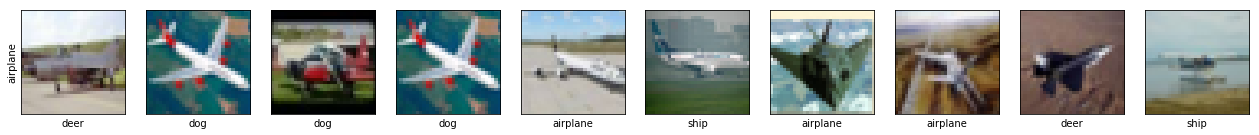

In [18]:
predict_and_plot('airplane')

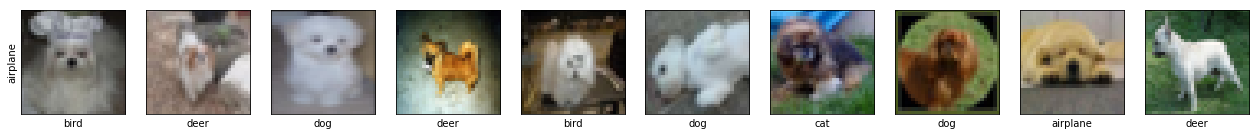

In [19]:
predict_and_plot('dog')

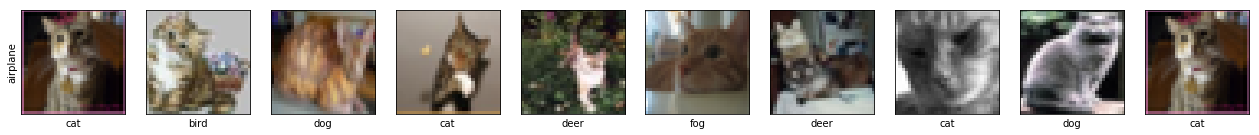

In [20]:
predict_and_plot('cat')

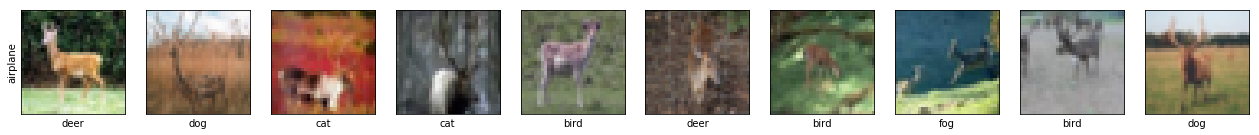

In [21]:
predict_and_plot('deer')